In [40]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
from mpl_toolkits import mplot3d
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('ggplot')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import crossmodal
import diffbayes
import fannypack
fannypack.data.set_cache_path(crossmodal.__path__[0] + "/../.cache")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# Choose experiment to eval
# experiment_name = "pf_blackout0.0_new"
# experiment_name = "pf_blackout0.0_nommpretrain"
Task = crossmodal.tasks.DoorTask
experiment_name = "cmpf_blackout0.0"

In [28]:
# Create Buddy, model
buddy = fannypack.utils.Buddy(experiment_name)
model_type = buddy.metadata["model_type"]
dataset_args = buddy.metadata["dataset_args"]
filter_model = Task.model_types[model_type]()
buddy.attach_model(filter_model)
buddy.load_checkpoint("phase3")

[buddy-cmpf_blackout0.0] Using device: cuda
[buddy-cmpf_blackout0.0] Loaded metadata: {'commit_hash': '19f068f366db5308eafe1eb9c19e0e3efc49c91f', 'dataset_args': {'image_blackout_ratio': 0.0, 'sequential_image_rate': 1, 'use_haptics': True, 'use_proprioception': True, 'use_vision': True}, 'model_type': 'DoorCrossmodalParticleFilter', 'notes': '(none)', 'train_start_time': 'Jul 31, 2020 @ 6:08:29'}
[buddy-cmpf_blackout0.0] Wrote metadata to: metadata/cmpf_blackout0.0.yaml
[buddy-cmpf_blackout0.0] Available checkpoint labels: ['0000000000223276', '0000000000224557', '0000000000225698', '0000000000226899', '0000000000228066', 'phase1', 'phase2', 'phase3']
[buddy-cmpf_blackout0.0] Read checkpoint from path: checkpoints/cmpf_blackout0.0-phase3.ckpt
[buddy-cmpf_blackout0.0] Instantiating optimizer:  train_measurement
[buddy-cmpf_blackout0.0] Instantiating optimizer:  train_filter_recurrent
[buddy-cmpf_blackout0.0] Loaded checkpoint at step: 201421


In [144]:
span_cm = 27
# span_cm = 23
resolution = 0.02
# 0.05650279, 0.0565098 => 5.65
span = span_cm / 5.65

def get_likelihood_map(traj, t, use_image=False, center_traj=None):
    if center_traj == None:
        center_traj = traj
    states, observations, controls = traj
    # Create delta
    grid_delta = np.mgrid[
        -span / 2.0 : span / 2.0 : resolution, -span / 2.0 : span / 2.0 : resolution
    ]
    _, grid_cols, grid_rows = grid_delta.shape
    grid_delta = grid_delta.T.reshape((1, grid_cols * grid_rows, 2))
    zero_col = np.zeros((1, grid_cols * grid_rows, 1))
    grid_delta = np.concatenate((zero_col, grid_delta), axis=2)
    assert grid_delta.shape == (1, grid_cols * grid_rows, 3)

    # Get state, observation
    zero_state_offset = center_traj[0][t : t + 1, None, :].copy()
    zero_state_offset[0, :, 0] = states[t : t + 1, 0]
    state_input = fannypack.utils.to_torch(
        zero_state_offset + grid_delta, device=buddy.device
    )
    observation_input = fannypack.utils.to_torch(
        fannypack.utils.SliceWrapper(observations)[t : t + 1], device=buddy.device
    )

    # Get measurement model
    measurement_model = filter_model.measurement_model
    model_name = ""
    if isinstance(
        filter_model.measurement_model,
        crossmodal.base_models.CrossmodalParticleFilterMeasurementModel,
    ):
        # Index 0 is image model, index 1 is proprioception/haptics
        if use_image:
            index = 0
        else:
            index = 1
        model_name = {0: "(image)", 1: "(proprioception + haptics)"}[index]
        measurement_model = measurement_model.measurement_models[index]

    # Compute weights
    with torch.no_grad():
        log_weights = measurement_model(states=state_input, observations=observation_input)
    weights = np.exp(fannypack.utils.to_numpy(log_weights))
    weights = weights.reshape((grid_cols, grid_rows)) / np.max(weights)
    return weights


In [153]:
# Load a trajectory
push_set = False

push_trajectories = crossmodal.tasks._door._load_trajectories(
#     ("panda_door_push_100.hdf5", 5), **dataset_args
     ("panda_door_push_100.hdf5"), **dataset_args
)
pull_trajectories = crossmodal.tasks._door._load_trajectories(
#     ("panda_door_push_100.hdf5", 5), **dataset_args
     ("panda_door_pull_100.hdf5"), **dataset_args
)

[TrajectoriesFile-...oor_push_100.hdf5] Loading trajectory from file: <HDF5 file "1JEDGZWpWE-Z9kuCvRBJh_Auhc-2V0UpN-panda_door_push_100.hdf5" (mode r)>
[TrajectoriesFile-...oor_push_100.hdf5] Existing trajectory count: 100
[TrajectoriesFile-...oor_push_100.hdf5] Opening file...
[TrajectoriesFile-...oor_push_100.hdf5] Closing file...
[TrajectoriesFile-...oor_pull_100.hdf5] Loading trajectory from file: <HDF5 file "1HCDnimAhCDP8OGZimWMRlq8MkrRzOcgf-panda_door_pull_100.hdf5" (mode r)>
[TrajectoriesFile-...oor_pull_100.hdf5] Existing trajectory count: 100
[TrajectoriesFile-...oor_pull_100.hdf5] Opening file...
[TrajectoriesFile-...oor_pull_100.hdf5] Closing file...


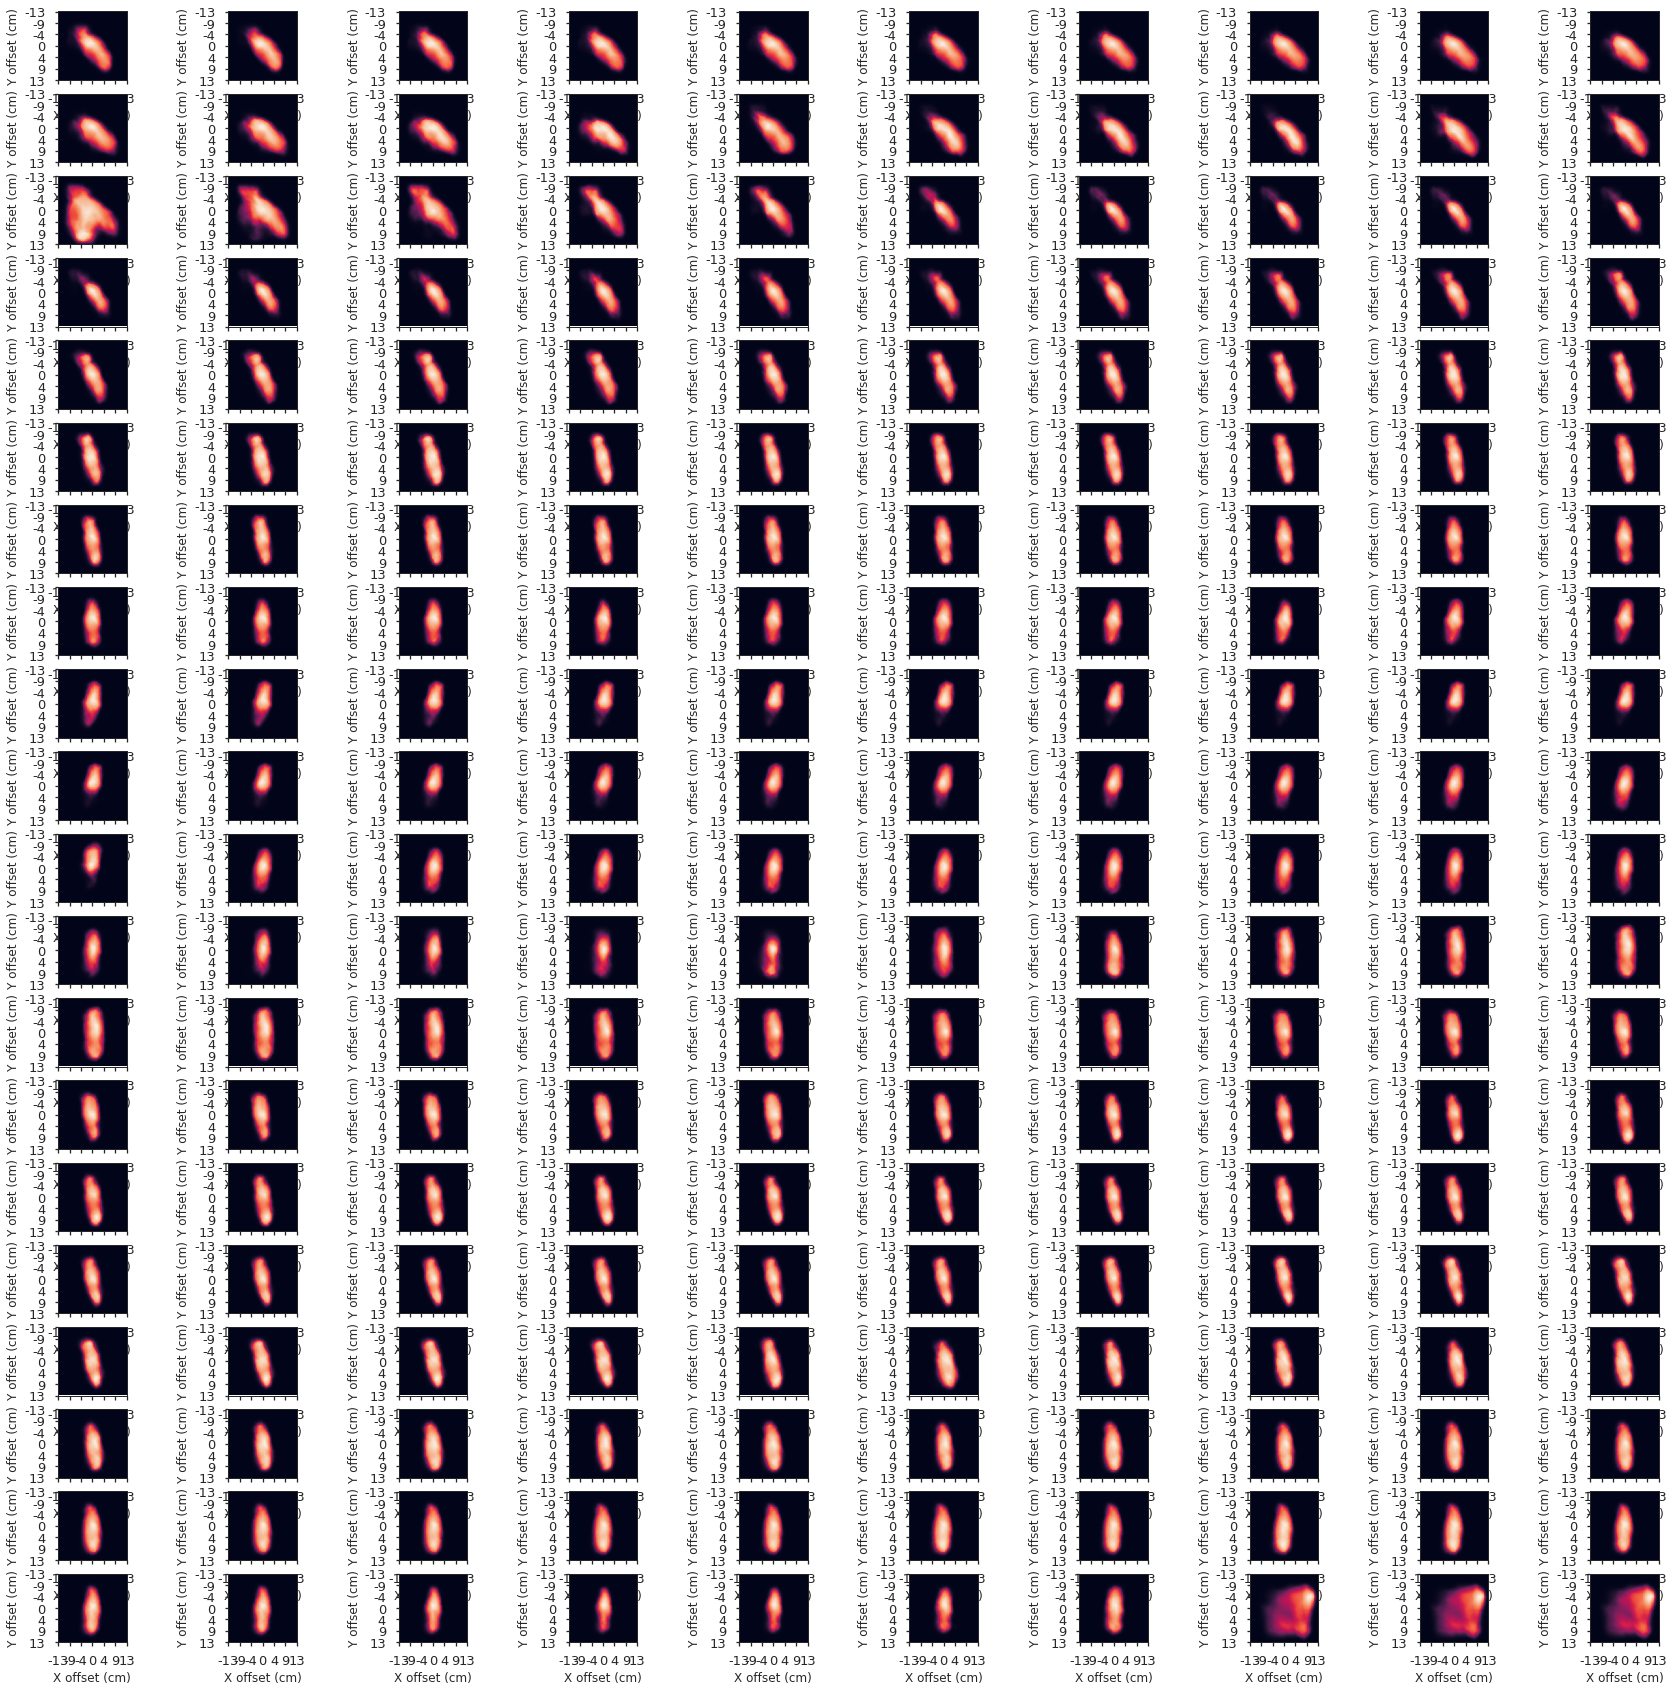

In [154]:
with sns.axes_style("ticks", {'axes.grid' : False}):

    timesteps = 200
    plots = [
#         get_likelihood_map(push_trajectories[7], t=0, center_traj=pull_trajectories[1]),
#         get_likelihood_map(pull_trajectories[1], t=30),
#         get_likelihood_map(pull_trajectories[1], t=7),,
#         get_likelihood_map(push_trajectories[1], t=t + 200)
        get_likelihood_map(pull_trajectories[1], t=t + 200)
        for t in range(timesteps)
        
    ]
    # sns.set_style("whitegrid", {'axes.grid' : False})


#     fig, axes = plt.subplots(4, 5, figsize=(15, 4))
    fig, axes = plt.subplots(20, 10, figsize=(30, 30))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        
        ax.imshow(plots[i])

        tick_count = 7
        ticks = np.linspace(0, plots[i].shape[0], num=tick_count)
        labels = np.linspace(-span_cm / 2.0, span_cm / 2, num=tick_count, dtype=np.int)

        ax.set_xticks(ticks)
        ax.set_xticklabels(labels)
        ax.set_yticks(ticks)
        ax.set_yticklabels(labels)
        ax.set_xlabel("X offset (cm)")
        ax.set_ylabel("Y offset (cm)")


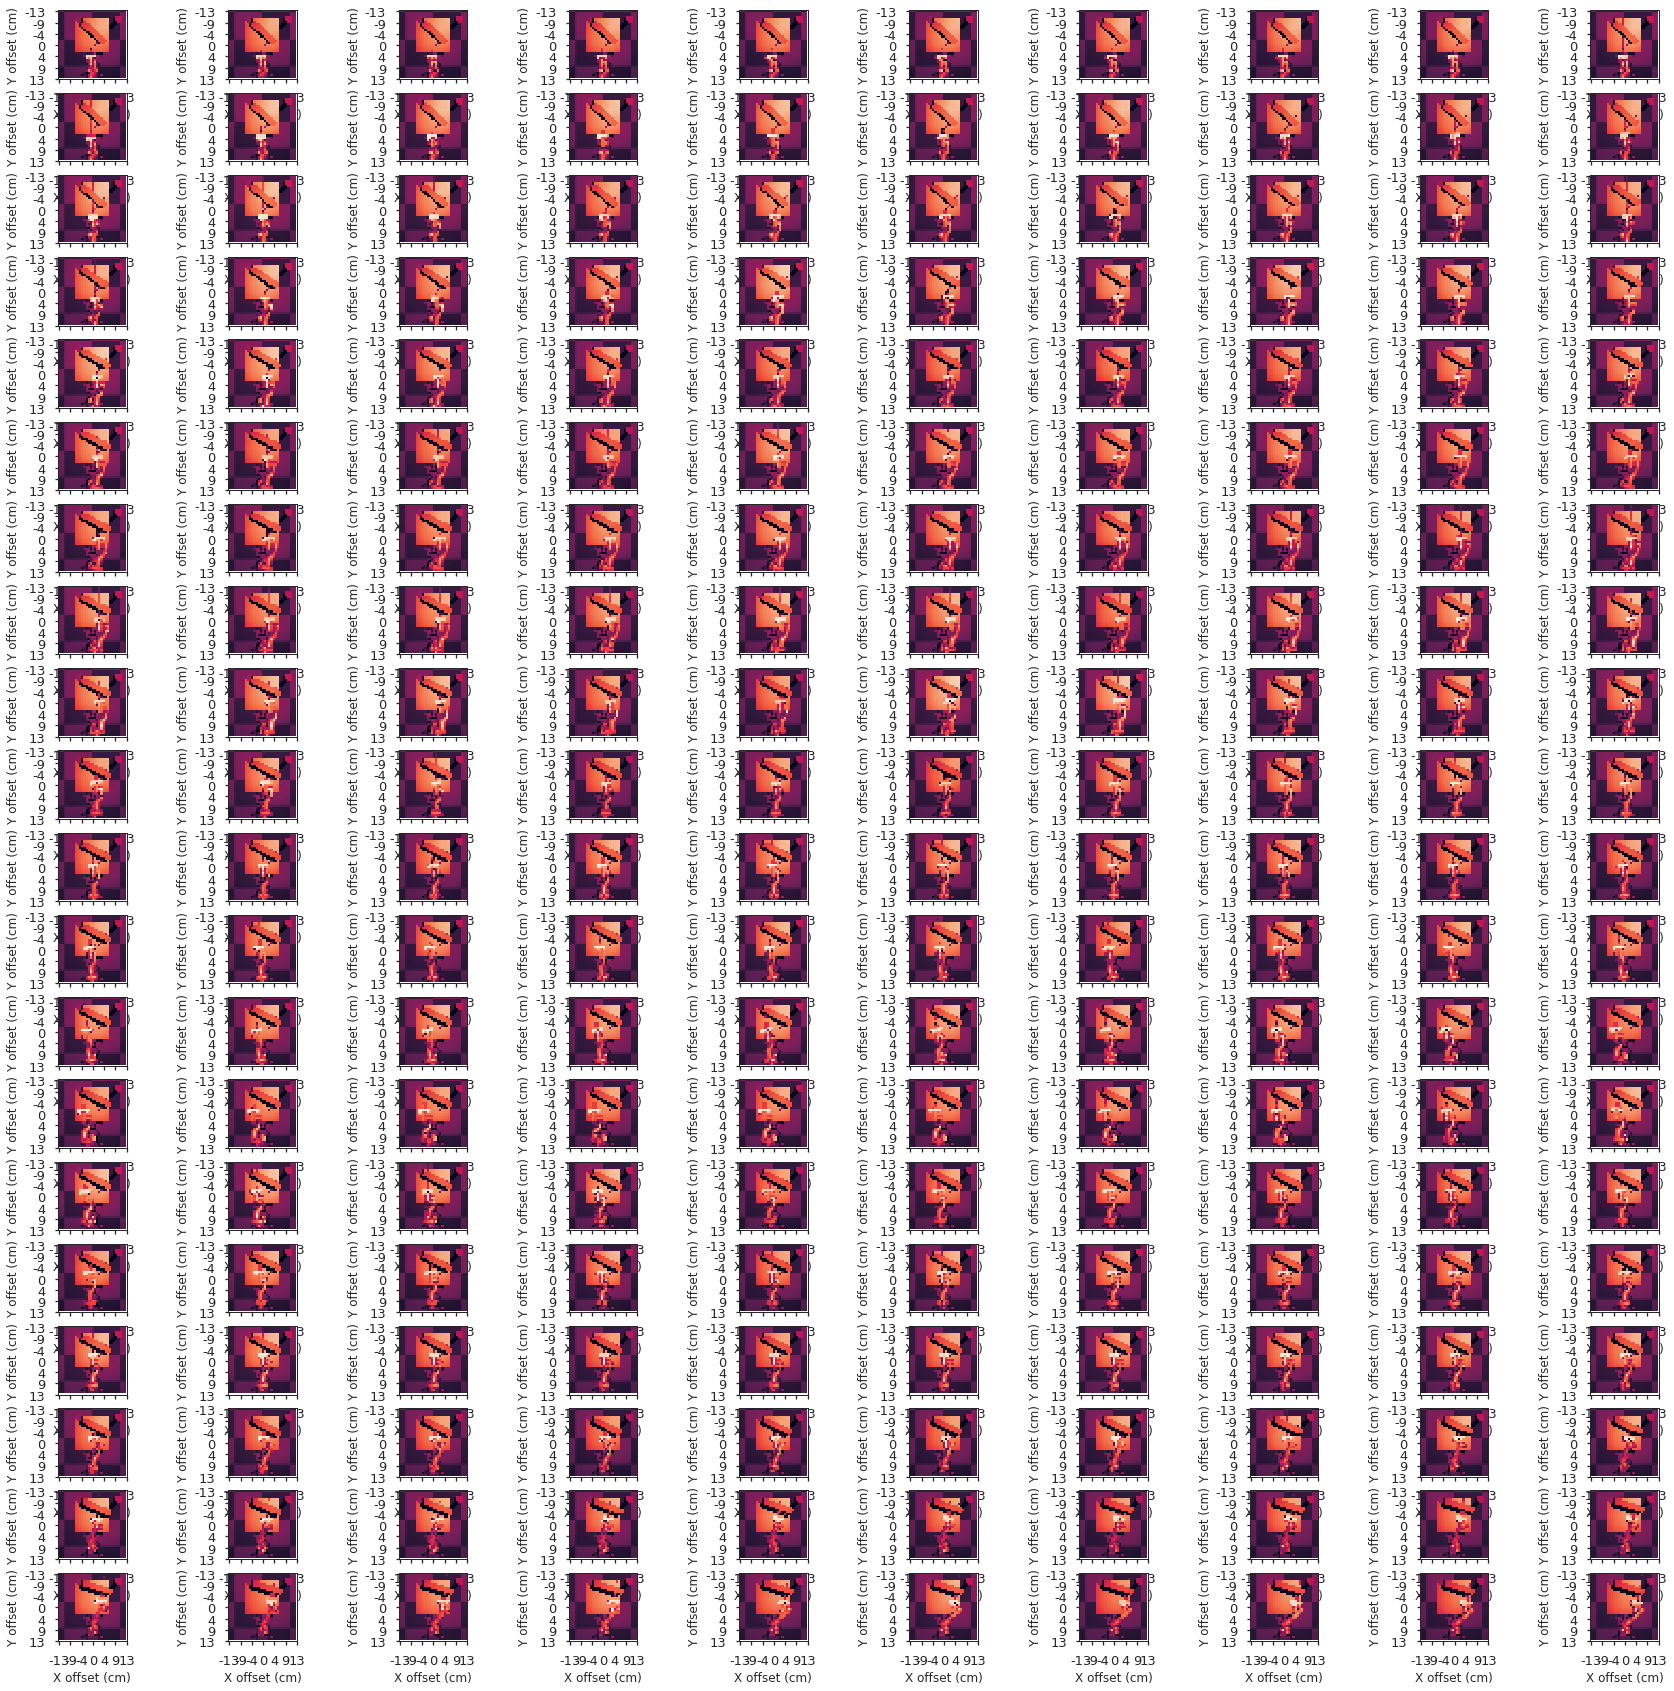

In [152]:
with sns.axes_style("ticks", {'axes.grid' : False}):

    timesteps = 200
    plots = [
#         get_likelihood_map(push_trajectories[7], t=0, center_traj=pull_trajectories[1]),
#         get_likelihood_map(pull_trajectories[1], t=30),
#         get_likelihood_map(pull_trajectories[1], t=7),,
#         get_likelihood_map(push_trajectories[1], t=t + 200)
        push_trajectories[1][1]["image"][t + 200]
        for t in range(timesteps)
        
    ]
    # sns.set_style("whitegrid", {'axes.grid' : False})


#     fig, axes = plt.subplots(4, 5, figsize=(15, 4))
    fig, axes = plt.subplots(20, 10, figsize=(30, 30))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        
        ax.imshow(plots[i])

        tick_count = 7
        ticks = np.linspace(0, plots[i].shape[0], num=tick_count)
        labels = np.linspace(-span_cm / 2.0, span_cm / 2, num=tick_count, dtype=np.int)

        ax.set_xticks(ticks)
        ax.set_xticklabels(labels)
        ax.set_yticks(ticks)
        ax.set_yticklabels(labels)
        ax.set_xlabel("X offset (cm)")
        ax.set_ylabel("Y offset (cm)")


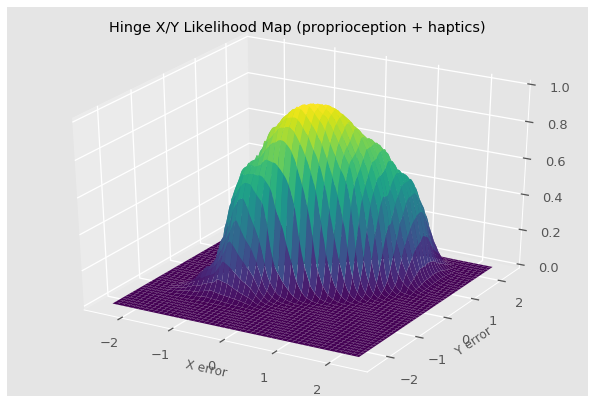

In [84]:
fig = plt.figure()
ax = plt.axes(projection="3d")

x = grid_delta[0, :, 1].reshape((grid_cols, grid_rows))
y = grid_delta[0, :, 2].reshape((grid_cols, grid_rows))

ax.plot_surface(x, y, weights, cmap="viridis", edgecolor="none", alpha=1.0)
# ax.plot_surface(x, y, weights_pretrain, cmap="plasma", edgecolor="none", alpha=0.3)

ax.set_title(f"Hinge X/Y Likelihood Map {model_name}")
ax.set_xlabel("X error")
ax.set_ylabel("Y error")
plt.show()

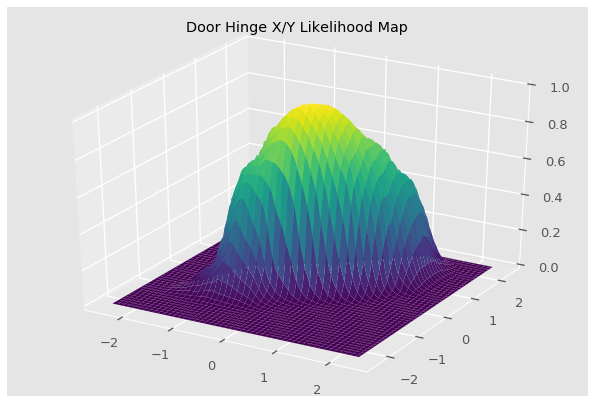

In [77]:
fig = plt.figure()
ax = plt.axes(projection="3d")

x = grid_delta[0, :, 1].reshape((grid_cols, grid_rows))
y = grid_delta[0, :, 2].reshape((grid_cols, grid_rows))

ax.plot_surface(x, y, weights, cmap="viridis", edgecolor="none", alpha=1.0)
# ax.plot_surface(x, y, weights_pretrain, cmap="plasma", edgecolor="none", alpha=0.3)

ax.set_title("Door Hinge X/Y Likelihood Map")
plt.show()

In [30]:
# Compute saliency
torch.mean(log_weights).backward(retain_graph=True)

In [31]:
image, saliency_map = fannypack.utils.to_numpy(
    [observation_input["image"][0, :, :], observation_input["image"].grad[0, :, :]]
)
saliency_map = np.abs(saliency_map)

fig, axes = plt.subplots(1, 2)
axes = axes.flatten()
axes[0].imshow(image)
axes[1].imshow(saliency_map)
fig.show()

TypeError: 'NoneType' object is not subscriptable

In [32]:
print(observation_input["gripper_pos"].grad)
print(observation_input["gripper_sensors"].grad)

tensor([[ 3.3854, -5.8738,  0.4430]], device='cuda:0')
tensor([[ 1.2563, -0.2116, -0.3108, -0.2650, -1.2925,  0.6730, -1.2703]],
       device='cuda:0')
